#### Toxicity: 
Using Sentiment Analysis, determine the top 5 positive subreddits and top 5 negative subreddits based on comment sentiment.

Choose two subreddits focused on similar topics but with different views, e.g., /r/apple and /r/android. Compare the toxicity of the two.

In [2]:
topic1 = 'apple'
topic2 = 'google'
topic3 = 'microsoft'

#### Loading data in dataframe

In [3]:
# from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col
conf = SparkConf().setAppName('FirstSpark2').setMaster('Spark')
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("hdfs://orion11:20001/sample_sampled_reddit/")

print(type(df))
print(df.count())
df.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
30926243
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

In [3]:
# from pyspark.sql.functions import lit
# df = df.withColumn("target", lit(0))
# df.show(1)

#### Filtering dataset

In [4]:
df2 = df.filter(
~(df.body.like('[deleted]'))
    & ~(df.body.isNull())
    & ~(df.author.like('[deleted]'))
    & ~(df.author.like('AutoModerator')) 
    & ~(df.author.rlike("[bB][oO][tT]"))

)

print(type(df2))
print(df2.count())
df2.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

#### Adding Sentiment score to each row 

In [28]:
%%time

# import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from pyspark.sql import functions as F
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# pattern = "\b[A-Z]+"

def getSentiment(body):
    ss = sid.polarity_scores(body)
    print(ss)
    return ss["compound"]

Score = udf(getSentiment, DoubleType())
df2 = df.withColumn('sentiment', Score("body"))
df2.show(1)

+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+---------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|sentiment|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+-

#### Group by subreddit and aggregate over sentiment to get average

In [6]:
groupedBysubreddit = df2.groupBy(df2.subreddit)
groupedBysubreddit = groupedBysubreddit.agg({'sentiment':'avg'})


#### Top 5 positive subreddits 

In [7]:
pos5 = groupedBysubreddit.orderBy('avg(sentiment)', ascending=False).show(5)

+---------------+--------------+
|      subreddit|avg(sentiment)|
+---------------+--------------+
|  CNGIntegrated|           1.0|
|ErinTillman2015|           1.0|
|       Athenian|           1.0|
|   seriousbroke|           1.0|
|         ps4bf5|        0.9999|
+---------------+--------------+
only showing top 5 rows



#### Top 5 negetive subreddits

In [8]:
neg5 = groupedBysubreddit.orderBy('avg(sentiment)', ascending=True).show(5)

+----------------+--------------+
|       subreddit|avg(sentiment)|
+----------------+--------------+
|    NatureTrails|          -1.0|
|syriantestsyrian|       -0.9999|
|       ARTNOTWAR|       -0.9999|
|          w0ls0n|       -0.9999|
|   deepspacepics|       -0.9999|
+----------------+--------------+
only showing top 5 rows



#### Comparing similar subreddit toxicity

In [9]:
comp = groupedBysubreddit.where(df2.subreddit.like(topic1) | df2.subreddit.like(topic2) | df2.subreddit.like(topic3))
comp.show()


+---------+-------------------+
|subreddit|     avg(sentiment)|
+---------+-------------------+
|microsoft|0.17381927244582035|
|    apple|0.15460784798099755|
|   google| 0.1350179478827362|
+---------+-------------------+



#### Bar Graph - Avg Sentiment vs subreddit

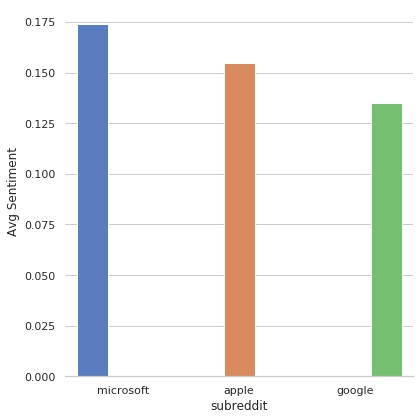

In [16]:
import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset

comp_P = comp.toPandas()




# Draw a nested barplot to show survival for avg(sentiment) and subreddit
g = sns.catplot(x="subreddit", y="avg(sentiment)", hue="subreddit", data=comp_P, height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Avg Sentiment")

#### Scatterplot of sentiment vs ups for different sub reddit

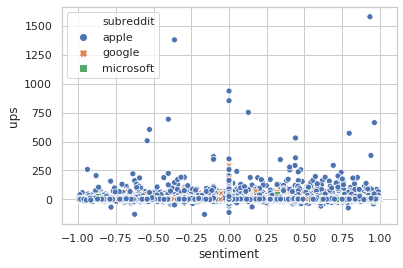

In [62]:

scatter_df = df2.select(df2.ups, df2.subreddit, df2.sentiment).where(df2.subreddit.like(topic1) | df2.subreddit.like(topic2) | df2.subreddit.like(topic3))

scatter_df_P = scatter_df.toPandas()


ax = sns.scatterplot(x="sentiment", y="ups", hue="subreddit", style="subreddit", data=scatter_df_P)